# The Fire Net Model

This is my own model using normal convolutions and we will also design one combining this model and depth wise separable convolutions as used in Mobile Net.

Therefore, for my project we have:
* A bench mark model which is a pre trained Mobile net.
* A fire net model made up of standard convolution.
* A fire net model made up of depthwise convolution.
* A model from PyImage Search.

In [3]:
import tensorflow as tf
import numpy as np
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow_hub as hub

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation


In [5]:
_URL = 'https://fire-net-datasets.s3.amazonaws.com/Training+Dataset.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,extract=True)  
#This will ge the file and extract it to a directory and extract to /Training Dataset

505036800/505020699 [==============================] - 9s 0us/step


In [6]:
print(os.path.dirname(zip_file))
#This function returns the directory of the extracted folder without the extracted folder inclusive

/root/.keras/datasets


In [7]:
base_dir = os.path.join(os.path.dirname(zip_file), 'Training Dataset')
#A good way to add the directory of the extracted folder and also the extracted folder itself.
print(base_dir)

/root/.keras/datasets/Training Dataset


In [8]:
classes = ['Fire', 'NoFire']

In [9]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Fire: 1124 Images
NoFire: 1301 Images


In [10]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [11]:
batch_size = 50
IMG_SHAPE = 128

In [31]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                    zoom_range = 0.5,
                    rotation_range=45,
                    horizontal_flip=True,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.2)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                            directory=train_dir,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            class_mode='binary')
print(train_data_gen.samples)
print(train_data_gen.n)
train_data_num = train_data_gen.samples
#Find our size of datasets. each

Found 1698 images belonging to 2 classes.
1698
1698


In [32]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

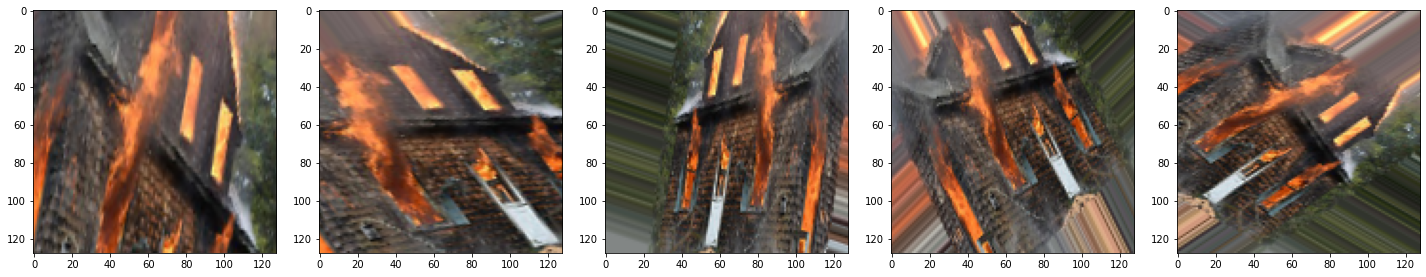

In [33]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [34]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                            directory=val_dir,
                            target_size=(IMG_SHAPE,IMG_SHAPE),
                            class_mode='binary',
                            shuffle = False)

Found 727 images belonging to 2 classes.


In [35]:
print(val_data_gen.samples)
print(val_data_gen.n)
val_data_num = val_data_gen.samples

727
727


In [36]:
model = Sequential()
model.add(Conv2D(16, 3, padding = "same", activation = 'relu', input_shape = (IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))

model.add(Dense(2, activation = 'softmax'))

### Places to test
0. Test with activation after Max Pool. (Performance Speed)
1. Overfit first so that you see maximum number of epoch.
2. Removing dropout on each layer or changing some of its values. (Overfitting or Not)
2. Discard dropout and use batch normalization. (Performance Accuracy)
4. Add a Dense layer of 128. (Accuracy)
5. MaxPooling to default stride (Accuracy) 
6. After finding best epoch, use reduce early and stop. (Generalizaation)

In [37]:
model.summary()

#Mobile Net had 2 million parameters

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)       

In [ ]:
EPOCHS = 50
model.compile(optimizer="adam",
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

history = model.fit(train_data_gen,epochs= EPOCHS,
                steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
                validation_data = val_data_gen,
                validation_steps = int(np.ceil(val_data_gen.n / float(batch_size))))

Epoch 1/50
34/34 [==============================] - 100s 2s/step - loss: 0.8553 - accuracy: 0.5342 - val_loss: 0.6806 - val_accuracy: 0.6547
Epoch 2/50
34/34 [==============================] - 65s 2s/step - loss: 0.6067 - accuracy: 0.6525 - val_loss: 0.6094 - val_accuracy: 0.6933
Epoch 3/50
34/34 [==============================] - 65s 2s/step - loss: 0.5235 - accuracy: 0.7444 - val_loss: 0.5731 - val_accuracy: 0.7304
Epoch 4/50
34/34 [==============================] - 65s 2s/step - loss: 0.5131 - accuracy: 0.7397 - val_loss: 0.5770 - val_accuracy: 0.7111
Epoch 5/50
34/34 [==============================] - 66s 2s/step - loss: 0.4874 - accuracy: 0.7839 - val_loss: 0.5562 - val_accuracy: 0.7180
Epoch 6/50
34/34 [==============================] - 65s 2s/step - loss: 0.4588 - accuracy: 0.7951 - val_loss: 0.5465 - val_accuracy: 0.7043
Epoch 7/50
34/34 [==============================] - 64s 2s/step - loss: 0.4741 - accuracy: 0.7744 - val_loss: 0.5351 - val_accuracy: 0.7263
Epoch 8/50
34/34 [=

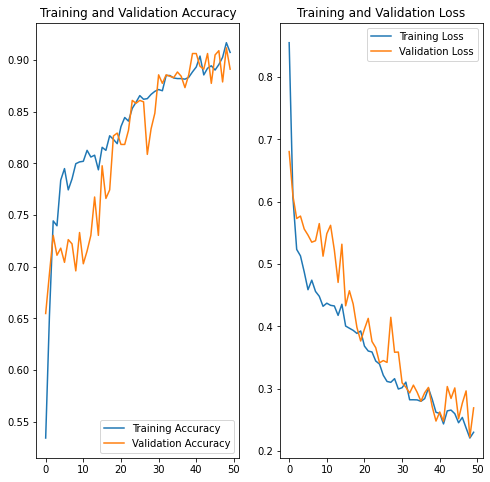

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [40]:
#Confusion Matrix and Classification Report
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[280  57]
 [ 22 368]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.93      0.83      0.88       337
     No Fire       0.87      0.94      0.90       390

    accuracy                           0.89       727
   macro avg       0.90      0.89      0.89       727
weighted avg       0.89      0.89      0.89       727

